In [9]:
import numpy as np
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
width, height = 100, 100
down_sample = 3
n_plot = 5
seq_len = 3

data = np.load("res_test_downsample3.npz")


In [10]:
np.random.seed(111)
idx = np.random.choice(range(100),n_plot, replace=False)

x = data['x'][idx]
A = data['A'][idx]


A = A.reshape((-1, 2, 3))

x_rep = []
for i in range(n_plot):
    x_rep += [np.repeat(x[i].reshape(1, height, width, 1), seq_len, axis=0)]

x_rep = np.vstack(x_rep)

print "A shape", A.shape
print x_rep.shape

A shape (15, 2, 3)
(15, 100, 100, 1)


In [11]:
def _repeat(x, n_repeats):
    rep = np.ones(n_repeats, dtype='int32').reshape(1, n_repeats)
    x = np.dot(x.reshape((-1, 1)), rep)
    return x.flatten()

def _channel_idx(channels, n_pixels):
    repeater = np.ones(n_pixels, dtype='int32').reshape((-1, 1))
    repeated_vec = np.arange(channels, dtype='int32').reshape((1, -1))
    return np.dot(repeater, repeated_vec).flatten()

def bilinear_interpolate(im, x, y, down_sampling_factor=1):
    
    # im shp is: (num_batch, height, width, channels)
    num_batch, height, width, channels = im.shape
    
    canvas = np.zeros(im.shape)

    #i = np.asarray([[i]*width*height for i in range(bs)]).flatten().astype('int32')

    x = (x + 1.0)*width / 2.0
    y = (y + 1.0)*height / 2.0

    x = np.asarray(x)
    y = np.asarray(y)

    x0 = np.floor(x).astype('int32')
    x1 = x0 + 1
    y0 = np.floor(y).astype('int32')
    y1 = y0 + 1


    x0 = np.clip(x0, 0, im.shape[2]-1)  #  width*height*bs
    x1 = np.clip(x1, 0, im.shape[2]-1)  #  width*height*bs
    y0 = np.clip(y0, 0, im.shape[1]-1)  #  width*height*bs
    y1 = np.clip(y1, 0, im.shape[1]-1)  #  width*height*bs
    #l = num_batch*height*width
    i = _repeat(np.arange(num_batch),
                (height//down_sampling_factor)*(width//down_sampling_factor))

    Ia = im[i, y0, x0]   # width*height*bs, num_channels
    Ib = im[i, y1, x0]   # width*height*bs, num_channels
    Ic = im[i, y0, x1]   # width*height*bs, num_channels
    Id = im[i, y1, x1]   # width*height*bs, num_channels
    
    canvas[i, y0, x0] = 1
    canvas[i, y1, x0] = 1
    canvas[i, y0, x1] = 1
    canvas[i, y1, x1] = 1
    

    wa = ((x1-x) * (y1-y)).reshape((-1, 1))  # width*height*bs
    wb = ((x1-x) * (y-y0)).reshape((-1, 1))  # width*height*bs
    wc = ((x-x0) * (y1-y)).reshape((-1, 1))  # width*height*bs
    wd = ((x-x0) * (y-y0)).reshape((-1, 1))  # width*height*bs

    distances = np.concatenate([wa, wb, wc, wd], axis=-1)
    aa2 = wa*Ia + wb*Ib + wc*Ic + wd*Id
    return aa2, canvas

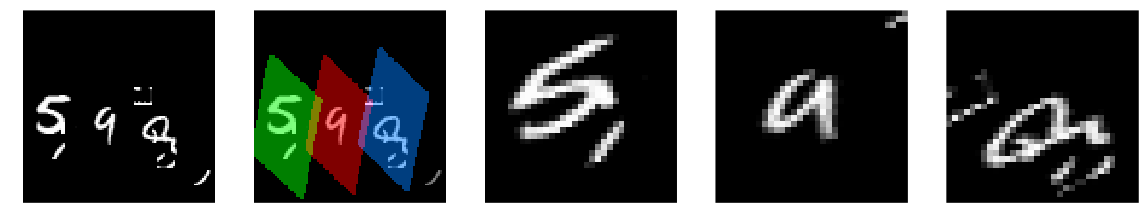

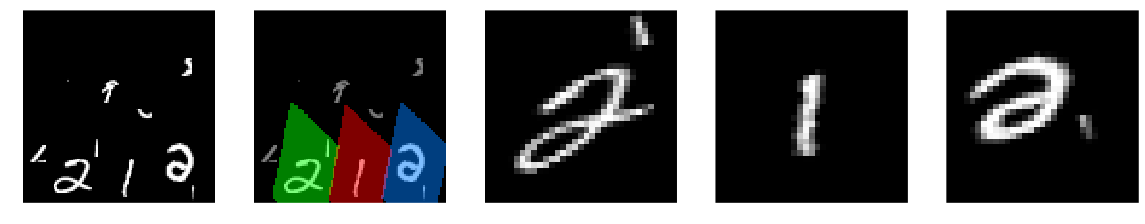

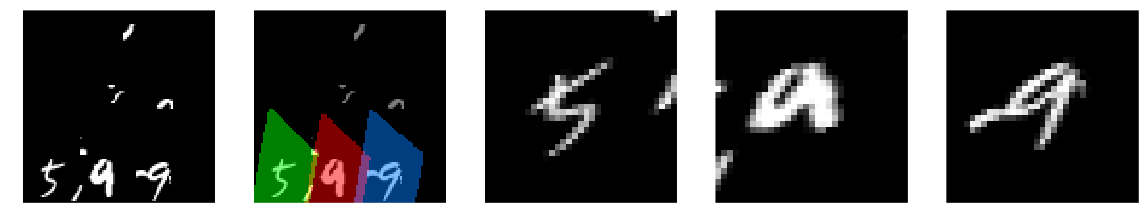

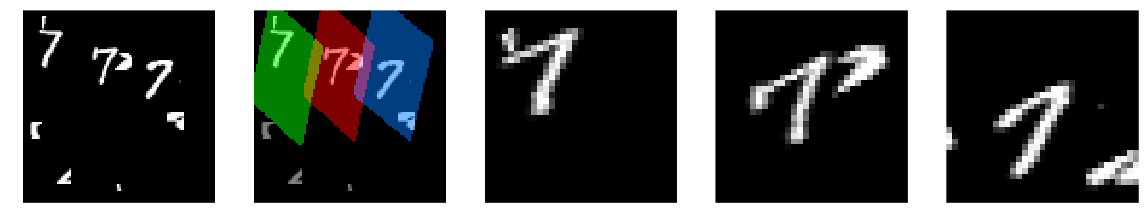

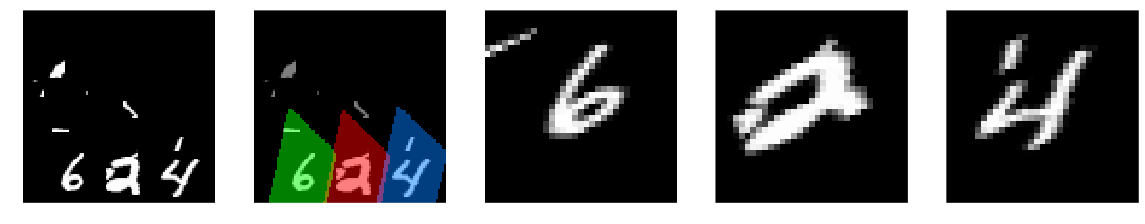

In [13]:
x_t, y_t = np.meshgrid(np.linspace(-1, 1, width//down_sample),
                       np.linspace(-1, 1, height//down_sample))
ones = np.ones(np.prod(x_t.shape))
x_y_one = np.vstack([x_t.flatten(), y_t.flatten(), ones])

transform = np.dot(A, x_y_one)
x_s, y_s = transform[:, 0], transform[:, 1]
x_s_flat = x_s.flatten()
y_s_flat = y_s.flatten()



x_transformed, canvas = bilinear_interpolate(x_rep, x_s_flat, y_s_flat, down_sampling_factor=down_sample)
x_out = x_transformed.reshape((-1, height//down_sample, width//down_sample))



from PIL import Image


output_images = []
canvas_start = 0
for x_idx in range(n_plot):
    

    x_ = x[x_idx].reshape((100,100))
    output_img = np.concatenate([[x_, x_, x_]]).transpose((1, 2, 0))

    color_img = np.zeros_like(output_img)

    output_img *= 255
    output_img = output_img.astype('uint8')


    #colors = np.array([[102,194,165], [252,141,98], [141,160,203]]).astype('float32')
    colors = np.array([[0, 255, 0], [255, 0, 0], [0, 125, 255]]).astype('float32')
    for i in range(3):
        att1 = canvas[canvas_start]
        att1 =  np.concatenate([att1, att1, att1], axis=2)
        att1 *= colors[i].reshape((1, 1, -1))
        #    c = [np.zeros_like(att1), np.zeros_like(att1),  att1]
        #c = np.concatenate(c, axis=2)
        mask = att1 == 0
        color_img *= mask
        color_img += att1
        canvas_start += 1


    output_img = Image.blend(Image.fromarray(color_img.astype('uint8')), 
                             Image.fromarray(output_img), 0.5)

    output_images +=[output_img]






pics = []
for row in range(n_plot):
    plt.figure(figsize=(20,20))
    row_pic = [np.ones((height//down_sample, 1))*1]
    for col in range(seq_len):     
        p = x_out[row*seq_len + col]
        plt.subplot(1, 5, col+2+1)
        plt.imshow(p, cmap='gray',  interpolation='none')
        plt.axis('off')
    #row_pic = np.hstack(row_pic)
    #plt.subplot(1, 2, 2)
    #plt.imshow(row_pic, cmap='gray')
    #plt.axis('off')
    plt.subplot(1, 5, 1)
    plt.imshow(x[row].reshape((100,100)), cmap='gray', interpolation='none')
    plt.axis('off')
    plt.subplot(1, 5, 2)
    plt.imshow(output_images[row], interpolation='none')
    
    plt.axis('off')
    plt.savefig('fig%i_sample' % row)
    #plt.show()
    
    #pics += [row_pic]
    #pics += [np.ones((2, pics[0].shape[-1]))]
    

#pics = np.vstack(pics)


In [128]:
print x.shape

(5, 100, 100)


In [126]:
a = [att1, np.zeros_like(att1), np.zeros_like(att1)]


In [72]:
l = [1, 2, 3]

In [74]:
l[::-2]

[3, 1]